In [15]:
## By: Payam Nasernejad


##inputs are chicago travel time, impedance and observation
##coincidence ratio and and trip distribution are the outputs

import numpy as np
import pandas as pd
from numpy import exp


In [16]:
tt_path = 'C:/Users/User/Desktop/583-chicago/2step/traveltime.csv' #path should be get from frontend
imp_path = 'C:/Users/User/Desktop/583-chicago/2step/impedance.csv' #form of (exp(beta*tt))* (tt^gamma)

### attraction and production should be copied from output of first step
att_path = 'C:/Users/User/Desktop/583-chicago/1step/taz_attraction.csv'
pro_path = 'C:/Users/User/Desktop/583-chicago/1step/taz_production.csv'
attraction = pd.read_csv(att_path, header = None).values
production = pd.read_csv(pro_path, header = None).values

##inputs
#Impedance function's parameters with general predefined form
##production and attraction matrix(from a step or manually)
###travel times within the study area(skim)(in minutes)

skim = pd.read_csv(tt_path, header=None).values


beta = pd.read_csv(imp_path)["Beta"].values
beta = -0.2
gamma = pd.read_csv(imp_path)["Gamma"].values

def imp_func(tt):
    f = (exp(beta*tt))*(tt**gamma)
    return f

imp_mat = np.zeros(skim.shape)

for i in range(len(imp_mat)):
    for j in range(len(imp_mat)):
        imp_mat[i][j] = imp_func(skim[i][j])

In [17]:
attraction

array([[16605324.15706407],
       [ 4169740.92766231],
       [  324341.99524863],
       [ 1401697.48440805],
       [  167117.56817083],
       [ 2233745.21524514],
       [  620755.06700858],
       [ 1460233.07048865],
       [  324341.99524863],
       [  324341.99524863],
       [  324341.99524863]])

In [18]:
a_inv = imp_mat.sum(axis = 1)
initializer_mat = np.zeros(skim.shape )
for i in range(len(imp_mat)):
    for j in range(len(imp_mat)):
        initializer_mat[i][j] = imp_mat[i][j]*production[i]/a_inv[i]
#first we modify attration and the production in each loop
modificaion_mat = initializer_mat.transpose()

loop_check = True
threshold = 0.001

while loop_check:

    #attraction
    a_sum = modificaion_mat.sum(axis=1)
    ratio = (attraction.transpose()/a_sum)[0]
    modificaion_mat = ratio * modificaion_mat.transpose()
    #production
    p_sum = modificaion_mat.sum(axis=1)
    ratio = (production.transpose()/p_sum)[0]
    modificaion_mat = ratio * modificaion_mat.transpose()
    
    loop_check = (abs(p_sum - production.transpose()) > threshold).all()
    
trips = modificaion_mat.transpose()
trips = np.ceil(trips)

In [19]:
trips.shape

(11, 11)

In [20]:
### comparing to observations and modifying impedance function
obs_path = 'C:/Users/User/Desktop/583-chicago/2step/observation.csv'
observation = pd.read_csv(obs_path)
time_steps = observation['Length<T(min)'].values
obs_trips = observation['Trips'].values
tot_obs = obs_trips.sum()
percent_obs = obs_trips*100/tot_obs


In [21]:
t_min = 0
t_max = 0
step_trips = np.zeros(len(time_steps))
for i in range(len(time_steps)):
    t_min = t_max
    t_max = time_steps[i]
    if t_max==t_min:
        step_trips[i] = trips[skim>t_max].sum()
    else:
        step_trips[i] = trips[skim<t_max].sum() - trips[skim<t_min].sum()

percent_trips = step_trips * 100 / step_trips.sum()


##CR
min_cr = np.min([percent_obs,percent_trips], axis = 0)
max_cr = np.max([percent_obs,percent_trips], axis = 0)

cr = min_cr.sum() / max_cr.sum()

np.save('TripDistribution', trips)

In [22]:
trips

array([[1.642350e+07, 3.628820e+05, 4.800000e+01, 2.446000e+03,
        4.100000e+01, 8.738000e+03, 3.000000e+01, 1.820000e+03,
        2.390000e+02, 1.000000e+00, 9.640000e+02],
       [3.996300e+04, 2.632140e+06, 2.330000e+02, 2.388570e+05,
        2.380000e+02, 8.577000e+03, 3.880000e+02, 4.855000e+03,
        2.600000e+01, 1.000000e+00, 1.000000e+00],
       [2.010000e+02, 1.610600e+04, 8.524700e+04, 1.786000e+03,
        8.717900e+04, 1.000000e+00, 1.000000e+00, 2.667000e+04,
        1.000000e+00, 1.000000e+00, 1.000000e+00],
       [8.370000e+02, 6.071940e+05, 4.400000e+01, 4.972840e+05,
        1.103000e+03, 6.570000e+03, 3.975550e+05, 1.020000e+02,
        1.000000e+00, 1.000000e+00, 1.000000e+00],
       [6.060000e+02, 3.986800e+04, 1.727660e+05, 3.988000e+04,
        6.499800e+04, 3.300000e+01, 2.400000e+01, 2.428700e+04,
        3.000000e+00, 1.000000e+00, 1.000000e+00],
       [2.700000e+01, 3.590000e+02, 1.000000e+00, 1.090000e+02,
        1.000000e+00, 2.098409e+06, 7.810

In [23]:
percent_trips


array([5.41181760e-01, 6.47854442e+01, 1.21417152e+01, 8.32187189e+00,
       1.30990932e+01, 7.68502923e-01, 2.76870381e-01, 5.54763797e-02,
       9.32893147e-03, 4.47130534e-04, 3.57704428e-05, 3.21933985e-05])

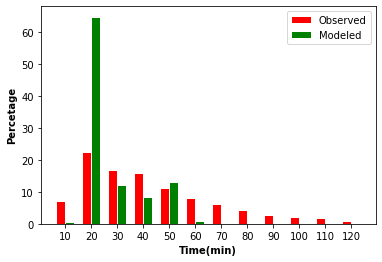

In [24]:
####histogram
%matplotlib inline
from matplotlib import pyplot as plt

barwidth = 0.35

r1 = np.arange(len(percent_obs))
r2 = r1 + barwidth

plt.bar(r1, percent_obs, color='red', width=barwidth, edgecolor='white', label='Observed')
plt.bar(r2, percent_trips, color='green', width=barwidth, edgecolor='white', label='Modeled')
plt.xlabel('Time(min)', fontweight='bold')
plt.ylabel('Percetage', fontweight='bold')

plt.xticks([r + barwidth/2 for r in range(len(percent_obs))], time_steps)


plt.legend()

plt.show()

###save trips 
from numpy import savetxt
savetxt("trip_distribution.csv", trips, delimiter = ',')


In [25]:
###save trips 
from numpy import savetxt
savetxt("trip_distribution.csv", trips, delimiter = ',')


In [126]:
cr

0.3880870788086173

In [12]:
trips

array([[1.64234995e+07, 3.62881730e+05, 4.78563476e+01, 2.44584151e+03,
        4.00696701e+01, 8.73723074e+03, 2.93213570e+01, 1.81925701e+03,
        2.38506037e+02, 2.98120610e-01, 9.63466637e+02],
       [3.99625973e+04, 2.63213988e+06, 2.32683516e+02, 2.38856919e+05,
        2.37958231e+02, 8.57686752e+03, 3.87529365e+02, 4.85448804e+03,
        2.59421767e+01, 1.78882449e-04, 1.75026745e-03],
       [2.00200899e+02, 1.61057213e+04, 8.52464167e+04, 1.78512214e+03,
        8.71788722e+04, 4.31903181e-01, 8.72331084e-01, 2.66696383e+04,
        1.44002778e-02, 4.91816801e-07, 4.78734429e-04],
       [8.36306129e+02, 6.07193752e+05, 4.39465767e+01, 4.97283460e+05,
        1.10256070e+03, 6.56901736e+03, 3.97554427e+05, 1.01590947e+02,
        1.09609151e-01, 1.85417396e-05, 2.70648082e-04],
       [6.05290993e+02, 3.98675428e+04, 1.72765303e+05, 3.98799942e+04,
        6.49975758e+04, 3.20351626e+01, 2.38027643e+01, 2.42863324e+04,
        2.90339338e+00, 2.20685581e-04, 1.17893149e-

In [13]:
np.ceil(trips)

array([[1.642350e+07, 3.628820e+05, 4.800000e+01, 2.446000e+03,
        4.100000e+01, 8.738000e+03, 3.000000e+01, 1.820000e+03,
        2.390000e+02, 1.000000e+00, 9.640000e+02],
       [3.996300e+04, 2.632140e+06, 2.330000e+02, 2.388570e+05,
        2.380000e+02, 8.577000e+03, 3.880000e+02, 4.855000e+03,
        2.600000e+01, 1.000000e+00, 1.000000e+00],
       [2.010000e+02, 1.610600e+04, 8.524700e+04, 1.786000e+03,
        8.717900e+04, 1.000000e+00, 1.000000e+00, 2.667000e+04,
        1.000000e+00, 1.000000e+00, 1.000000e+00],
       [8.370000e+02, 6.071940e+05, 4.400000e+01, 4.972840e+05,
        1.103000e+03, 6.570000e+03, 3.975550e+05, 1.020000e+02,
        1.000000e+00, 1.000000e+00, 1.000000e+00],
       [6.060000e+02, 3.986800e+04, 1.727660e+05, 3.988000e+04,
        6.499800e+04, 3.300000e+01, 2.400000e+01, 2.428700e+04,
        3.000000e+00, 1.000000e+00, 1.000000e+00],
       [2.700000e+01, 3.590000e+02, 1.000000e+00, 1.090000e+02,
        1.000000e+00, 2.098409e+06, 7.810

In [11]:
trips[skim<2].sum()

0.0

In [12]:
trips[skim<4].sum()

0.0

In [13]:
percent_obs

array([ 7.11610487, 22.47191011, 16.85393258, 15.917603  , 11.32958801,
        7.9588015 ,  6.27340824,  4.3071161 ,  2.80898876,  2.24719101,
        1.87265918,  0.84269663])

In [14]:
a_sum = modificaion_mat.sum(axis=1)
ratio = (attraction.transpose()/a)[0]


NameError: name 'a' is not defined

In [15]:
ratio

array([1.0000012 , 0.99999973, 0.99999973, 1.        , 0.99999973,
       0.99999342, 0.99999336, 0.99999973, 0.99999974, 1.00000099,
       1.0000012 ])

In [16]:
imp_mat

array([[5.53461007e-12, 3.08493835e-18, 3.66980264e-31, 6.53748667e-30,
        2.07466047e-27, 1.70739309e-29, 2.04551265e-37, 5.45685189e-22,
        5.41838343e-27, 1.69535670e-34, 3.08493835e-18],
       [1.18120095e-18, 2.13420807e-07, 2.52092860e-25, 8.05692261e-18,
        3.72209601e-21, 5.41838343e-27, 1.70739309e-29, 2.10422364e-17,
        4.45919250e-29, 2.01677433e-47, 2.97772325e-43],
       [5.38018616e-32, 1.71951493e-24, 8.17173088e-08, 2.50315714e-30,
        3.77513454e-11, 6.35508100e-50, 1.67153788e-44, 3.74852147e-16,
        5.26720242e-47, 5.15659133e-62, 2.95673158e-48],
       [2.50315714e-30, 3.08493835e-18, 2.06003501e-32, 1.19803264e-08,
        1.42516408e-21, 3.66980264e-31, 1.18120095e-18, 4.45919250e-29,
        4.36554960e-44, 9.25131041e-56, 9.31699119e-51],
       [7.94372734e-28, 9.72098502e-21, 5.53461007e-12, 5.45685189e-22,
        9.92950431e-06, 4.39654334e-39, 9.51684463e-36, 1.74401740e-14,
        4.42775712e-34, 2.01677433e-47, 6.49140020e-

In [17]:
attraction

array([[17826472.51041811],
       [ 4476381.87122749],
       [  348193.96523579],
       [ 1504777.71089416],
       [  179407.32182201],
       [ 2398013.87182831],
       [  666405.12603445],
       [ 1567617.97864666],
       [  348193.96523579],
       [  348193.96523579],
       [  348193.96523579]])

In [18]:
production

array([[16800703.05816244],
       [ 2925274.86243523],
       [  858685.36979744],
       [ 1510685.17108463],
       [  342460.89918261],
       [ 2099683.22678979],
       [  951938.60095744],
       [ 1946364.95401245],
       [  858685.36979744],
       [  858685.36979744],
       [  858685.36979744]])

In [19]:
imp_mat

array([[5.53461007e-12, 3.08493835e-18, 3.66980264e-31, 6.53748667e-30,
        2.07466047e-27, 1.70739309e-29, 2.04551265e-37, 5.45685189e-22,
        5.41838343e-27, 1.69535670e-34, 3.08493835e-18],
       [1.18120095e-18, 2.13420807e-07, 2.52092860e-25, 8.05692261e-18,
        3.72209601e-21, 5.41838343e-27, 1.70739309e-29, 2.10422364e-17,
        4.45919250e-29, 2.01677433e-47, 2.97772325e-43],
       [5.38018616e-32, 1.71951493e-24, 8.17173088e-08, 2.50315714e-30,
        3.77513454e-11, 6.35508100e-50, 1.67153788e-44, 3.74852147e-16,
        5.26720242e-47, 5.15659133e-62, 2.95673158e-48],
       [2.50315714e-30, 3.08493835e-18, 2.06003501e-32, 1.19803264e-08,
        1.42516408e-21, 3.66980264e-31, 1.18120095e-18, 4.45919250e-29,
        4.36554960e-44, 9.25131041e-56, 9.31699119e-51],
       [7.94372734e-28, 9.72098502e-21, 5.53461007e-12, 5.45685189e-22,
        9.92950431e-06, 4.39654334e-39, 9.51684463e-36, 1.74401740e-14,
        4.42775712e-34, 2.01677433e-47, 6.49140020e-